In [1]:
## Importing Important library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [2]:
df = pd.read_excel('C:/Users/priya/Downloads/Book1.xlsx')

In [3]:
df.head()

,x1,x1.1,x3,x4,y
0,7,16,21,27,13
1,7,16,13,23,18
2,1,29,21,14,10
3,7,16,29,20,14
4,7,29,28,16,10


## EDA 

In [4]:
df.describe()

,x1,x1.1,x3,x4,y
count,20.000000,20.000000,20.00000,20.000000,20.000000
mean,6.400000,20.100000,21.70000,21.250000,15.400000
std,2.722228,5.543132,6.71291,6.111895,3.168928
min,1.000000,11.000000,11.00000,12.000000,10.000000
25%,5.750000,16.000000,16.00000,15.500000,13.750000
50%,7.000000,20.500000,22.00000,22.000000,16.000000
75%,8.000000,24.000000,28.00000,26.250000,17.250000
max,10.000000,29.000000,30.00000,30.000000,20.000000


Text(0.5, 1.0, 'y trend ')

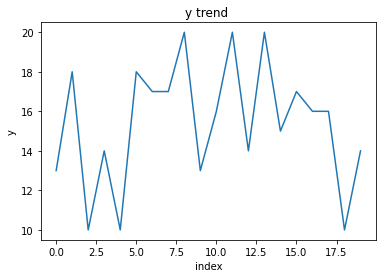

In [5]:
plt.plot('y',data=df)
plt.xlabel('index')
plt.ylabel('y')
plt.title('y trend ')

### Seasonal Decomposition

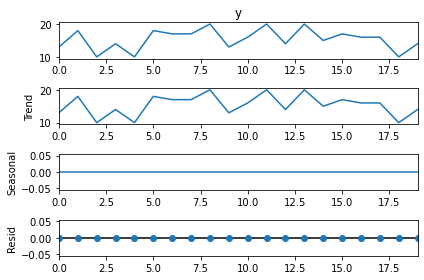

In [6]:
x = seasonal_decompose(df['y'],period=1).plot()

-  didn't get any trend 

### Split Data into Test and Train Data

In [7]:
train_data  = df.iloc[0: int(len(df)*0.8),]
test_data  = df.iloc[int(len(df)*0.8) : ,]
y =df[['y']]
x_train = train_data[['x1', 'x1.1', 'x3', 'x4']]
y_train = train_data[['y']]
x_test = test_data[['x1', 'x1.1', 'x3', 'x4']]
y_test = test_data[['y']] 

In [9]:
n_input =2 # past value to predict
n_features = 5

train_data = df.iloc[0: int(len(df)*0.8), ]
test_data = df.iloc[int(len(df)*0.8)-n_input : , ] ## used to predict target variable crossponding to test data
actual_test_data = df.iloc[int(len(df)*0.8) : , ] 


scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_st = scaler.transform(train_data)
test_data_st = scaler.transform(test_data)
y_scaler = MinMaxScaler()
y_scaler.fit(y_train[['y']])

train_gen = TimeseriesGenerator(train_data_st,train_data_st[ : , -1], length= n_input,batch_size = 1)
test_gen = TimeseriesGenerator(test_data_st,test_data_st[ : , -1],length= n_input,batch_size = 1)

In [10]:
y_train

,y
0,13
1,18
2,10
3,14
4,10
5,18
6,17
7,17
8,20
9,13


### ARIMA Model

Text(0.5, 1.0, 'Autocorelation plot ')

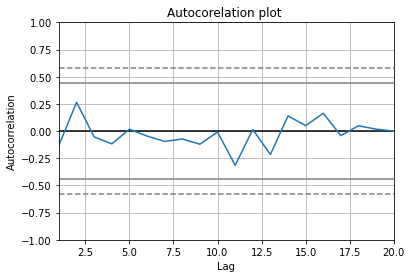

In [11]:
pd.plotting.autocorrelation_plot(y)
plt.title('Autocorelation plot ')

## --- 99% confidence level ,_____ 95% confidence level 

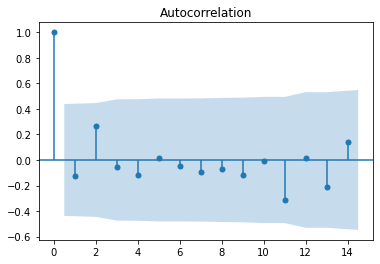

In [12]:
X = plot_acf(y)

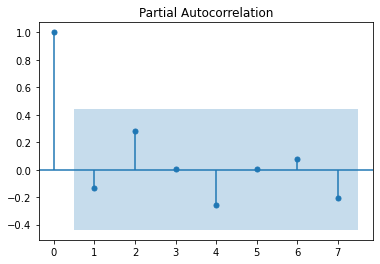

In [13]:
X = plot_pacf(y,lags= 7)

In [14]:
## Since there is no trend --- d = 0 , p = [1,2,3] , q = [1,2 ,3]

In [15]:
model = ARIMA(y_train,order=(1, 0, 1))
model_fit = model.fit()

In [16]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   16
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -40.326
Date:                Tue, 01 Feb 2022   AIC                             88.652
Time:                        01:22:06   BIC                             91.743
Sample:                             0   HQIC                            88.811
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7696      0.868     18.163      0.000      14.068      17.471
ar.L1         -0.6472      0.802     -0.807      0.420      -2.220       0.925
ma.L1          0.4183      1.001      0.418      0.6

<AxesSubplot:>

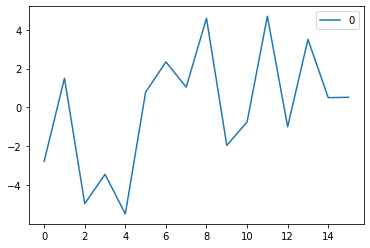

In [17]:
residual = pd.DataFrame(model_fit.resid)
residual.plot()

<AxesSubplot:ylabel='Density'>

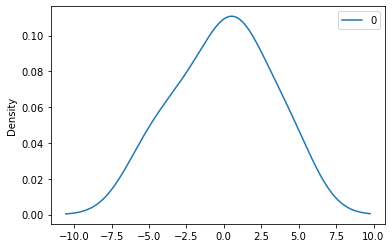

In [18]:
residual.plot(kind = 'kde')

In [19]:
y_test['y_pred'] = model_fit.forecast(steps=4)

In [23]:
order = [(1,0,1),(1,0,2),(1,0,3),(2,0,1),(2,0,2),(2,0,3),(3,0,1),(3,0,2),(3,0,3)]
res = {}
for i in order :
    model = ARIMA(y_train['y'],order= i )
    model_fit = model.fit()
    y_train['predicted_value'] = model_fit.predict()
    res[i] =  (model_fit.resid.mean(),mean_squared_error(y_train['y'], y_train['predicted_value'], squared=False))

In [25]:
res

{(1, 0, 1): (-0.0522692229807139, 3.0064347582234787),
 (1, 0, 2): (-0.1360425378177078, 2.665932038310189),
 (1, 0, 3): (-0.11298520635706044, 2.6669114152716658),
 (2, 0, 1): (-0.0237683572732178, 2.911237859605038),
 (2, 0, 2): (-0.12233924085111614, 2.631394591784922),
 (2, 0, 3): (-0.4820316870658564, 2.5770814125907675),
 (3, 0, 1): (0.007107587443150876, 2.8708638761478005),
 (3, 0, 2): (-0.0632444890952838, 2.8047737481488033),
 (3, 0, 3): (-0.47072248864034494, 2.5757119757562763)}

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   16
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 -39.581
Date:                Tue, 01 Feb 2022   AIC                             91.163
Time:                        01:24:25   BIC                             95.798
Sample:                             0   HQIC                            91.400
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7630      1.119     14.083      0.000      13.569      17.957
ar.L1         -0.7583      0.799     -0.949      0.343      -2.325       0.809
ar.L2          0.2182      0.352      0.620      0.5

<AxesSubplot:ylabel='Density'>

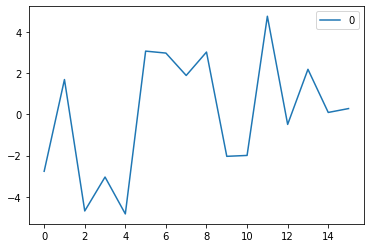

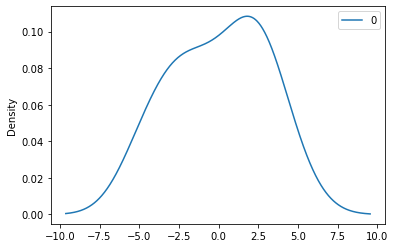

In [26]:
## Selected model 
## p = 3, d = 0 , q = 1   have residual mean = 0.007107587443150876 and RMS in train data = 2.8708638761478005
model = ARIMA(y_train['y'],order=(3, 0, 1))
model_fit = model.fit()
print(model_fit.summary())
residual = pd.DataFrame(model_fit.resid)
residual.plot()
residual.plot(kind = 'kde')

In [27]:
y_test['y_pred'] = model_fit.forecast(steps=4)

In [28]:
y_test

,y,y_pred
16,16,16.269238
17,16,15.388867
18,10,16.578706
19,14,15.235323


In [29]:
## RMS on test Data

mean_squared_error(y_test['y'], y_test['y_pred'],squared=False)

3.3634568016578856

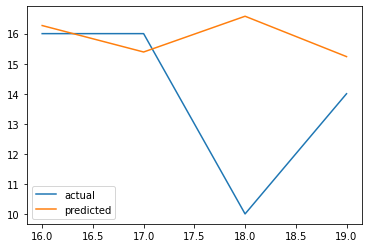

In [30]:
plt.plot(y_test['y'],label= 'actual')
plt.plot(y_test['y_pred'],label= 'predicted')
plt.legend()

In [31]:
# LSTM,SVM,ANN 

## Decision tree

In [32]:
regressor = DecisionTreeRegressor(criterion='mse',random_state = 0)
regressor.fit(x_train[ : len(x_train)-1 ],y_train['y'][1:])    ## Assume at time 't' value will predict t+1

DecisionTreeRegressor(random_state=0)

In [33]:
regressor.predict(x_train)

array([18., 10., 14., 10., 18., 17., 17., 20., 13., 16., 20., 14., 20.,
       15., 17., 10.])

In [34]:
y_train['predicted_value'] =np.nan
y_train['predicted_value'][1 : ] = regressor.predict(x_train)[ :  -1]

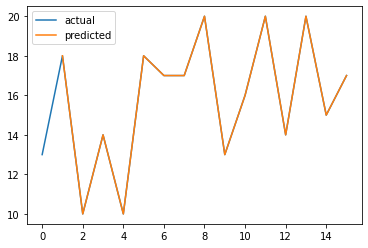

In [35]:
plt.plot(y_train[['y']],label= 'actual')
plt.plot(y_train[['predicted_value']],label= 'predicted')
plt.legend()

In [36]:
## Above show Overfitting problems

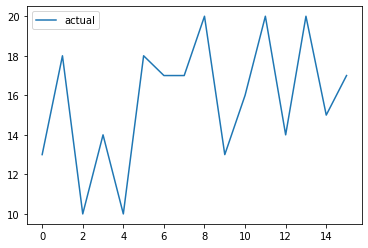

In [37]:
plt.plot(y_train[['y']],label= 'actual')
plt.legend()

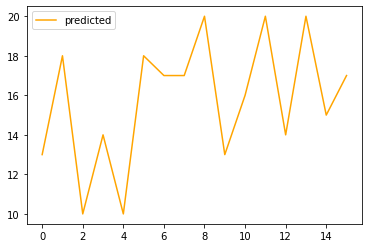

In [38]:
plt.plot(y_train[['y']],label= 'predicted',color='orange')
plt.legend()

In [39]:
y_test['predicted_y'] = np.nan

y_test['predicted_y'][1 : ] = regressor.predict(x_test)[ : -1]

Text(0.5, 1.0, 'predicted vs Actual values')

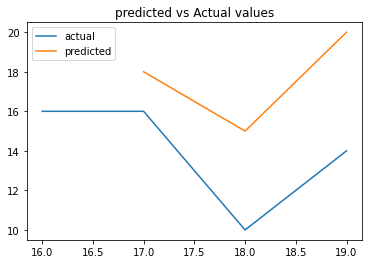

In [40]:
plt.plot(y_test[['y']],label= 'actual')
plt.plot(y_test[['predicted_y']],label= 'predicted')
plt.legend()
plt.title('predicted vs Actual values')

In [41]:
y_test.dropna()

,y,y_pred,predicted_y
17,16,15.388867,18.0
18,10,16.578706,15.0
19,14,15.235323,20.0


In [42]:
mean_squared_error(y_test.dropna()['y'], y_test.dropna()['predicted_y'],squared=False)

4.654746681256314

## SVM

In [43]:
regressor = LinearSVR(loss = 'squared_epsilon_insensitive')
regressor.fit(x_train[ : len(x_train)-1 ],y_train['y'][1:])

LinearSVR(loss='squared_epsilon_insensitive')

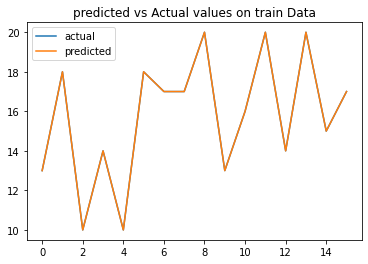

In [44]:
y_train['predicted_value'] =np.nan
y_train['predicted_value'][1 : ] = regressor.predict(x_train)[ :  -1]
plt.plot(y_train[['y']],label= 'actual')
plt.plot(y_train[['y']],label= 'predicted')
plt.title('predicted vs Actual values on train Data')
plt.legend()

Text(0.5, 1.0, 'predicted vs Actual values on test Data')

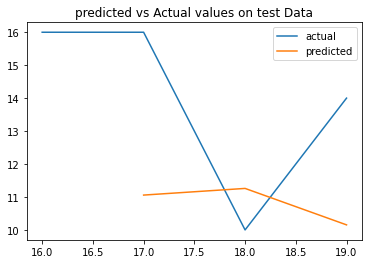

In [45]:
y_test['predicted_y'] = np.nan
y_test['predicted_y'][1 : ] = regressor.predict(x_test)[ : -1]

plt.plot(y_test[['y']],label= 'actual')
plt.plot(y_test[['predicted_y']],label= 'predicted')
plt.legend()
plt.title('predicted vs Actual values on test Data')

In [46]:
mean_squared_error(y_test.dropna()['y'], y_test.dropna()['predicted_y'],squared=False)

3.688341027612768

## LSTM

In [47]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input =2 # past value to predict
n_features = 5

train_data = df.iloc[0: int(len(df)*0.8), ]
test_data = df.iloc[int(len(df)*0.8)-n_input : , ]
actual_test_data = df.iloc[int(len(df)*0.8) : , ]


scaler = MinMaxScaler()
scaler.fit(train_data)

train_data_st = scaler.transform(train_data)
test_data_st = scaler.transform(test_data)

train_gen = TimeseriesGenerator(train_data_st,train_data_st[ : , -1], length= n_input,batch_size = 1)
test_gen = TimeseriesGenerator(test_data_st,test_data_st[ : , -1],length= n_input,batch_size = 1)

In [48]:
batch_0 = train_gen[1]  # t-2, t-1,t

x,y = batch_0
print(x, y)

[[[0.66666667 0.27777778 0.10526316 0.61111111 0.8       ]
  [0.         1.         0.52631579 0.11111111 0.        ]]] [0.4]


In [49]:
train_gen[0]

(array([[[0.66666667, 0.27777778, 0.52631579, 0.83333333, 0.3       ],
         [0.66666667, 0.27777778, 0.10526316, 0.61111111, 0.8       ]]]),
 array([0.]))

In [50]:
epoch  = 100
model = Sequential()
model.add(LSTM(30,activation = 'sigmoid',input_shape = (n_input,n_features)))

model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(train_gen,epochs = epoch,batch_size = 1 , shuffle = False)

Epoch 1/100
14/14 [==============================] - 1s 2ms/step - loss: 0.9256
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4156
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1787
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1064
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0980
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1011
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1024
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1023
Epoch 9/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1018
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1014
Epoch 11/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1010
Epoch 12/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1007
Epoch 13/100
14/14 [=================

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                4320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 4,351
Trainable params: 4,351
Non-trainable params: 0
_________________________________________________________________


In [52]:
true_predictions = y_scaler.inverse_transform(model.predict(test_gen))

In [53]:
model.predict(test_gen)

array([[0.49856952],
       [0.623948  ],
       [0.49043053],
       [0.570797  ]], dtype=float32)

In [54]:
true_predictions

array([[14.985695],
       [16.23948 ],
       [14.904306],
       [15.70797 ]], dtype=float32)

In [55]:
actual_test_data['y_pred'] = true_predictions

In [56]:
actual_test_data

,x1,x1.1,x3,x4,y,y_pred
16,10,12,11,28,16,14.985695
17,8,17,25,23,16,16.239479
18,5,20,23,12,10,14.904306
19,8,24,21,25,14,15.707970


### RMS on Sample Data

In [58]:
mean_squared_error(actual_test_data['y'], actual_test_data['y_pred'],squared=False)

2.648374352644089